In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


In [2]:
# read excel and geenrate dataframe
np.random.seed(3)
raw_dataset = pd.DataFrame(pd.read_excel(r'dataset_watermelon3.xlsx'))
raw_dataset = raw_dataset.sample(frac = 1).reset_index(drop=True) # shuffle
raw_dataset.loc[raw_dataset['好瓜']=='是','好瓜']=1
raw_dataset.loc[raw_dataset['好瓜']=='否','好瓜']=0
print(raw_dataset)

# one-hot encoding
dataset = pd.DataFrame()
for col in raw_dataset.iloc[:,:-3].columns :
    for element in raw_dataset[col].unique():
        dataset[col+element]=np.zeros_like(raw_dataset[col])
        dataset.loc[raw_dataset[col]==element,col+element]=1
for col in raw_dataset.iloc[:,-3:].columns :
    dataset[col]=raw_dataset[col]
    
print(dataset)


    色泽  根蒂  敲声  纹理  脐部  触感     密度    含糖率  好瓜
0   青绿  蜷缩  沉闷  稍糊  稍凹  硬滑  0.719  0.103   0
1   乌黑  稍蜷  浊响  稍糊  稍凹  软粘  0.481  0.149   1
2   浅白  蜷缩  浊响  清晰  凹陷  硬滑  0.556  0.215   1
3   乌黑  稍蜷  浊响  清晰  稍凹  硬滑  0.437  0.211   1
4   乌黑  稍蜷  浊响  清晰  稍凹  软粘  0.360  0.370   0
5   乌黑  蜷缩  沉闷  清晰  凹陷  硬滑  0.774  0.376   1
6   浅白  蜷缩  浊响  模糊  平坦  软粘  0.343  0.099   0
7   乌黑  蜷缩  浊响  清晰  凹陷  硬滑  0.634  0.264   1
8   浅白  稍蜷  沉闷  稍糊  凹陷  硬滑  0.657  0.198   0
9   青绿  稍蜷  浊响  清晰  稍凹  软粘  0.403  0.237   1
10  青绿  蜷缩  浊响  清晰  凹陷  硬滑  0.697  0.460   1
11  青绿  稍蜷  浊响  稍糊  凹陷  硬滑  0.639  0.161   0
12  浅白  蜷缩  浊响  模糊  平坦  硬滑  0.593  0.042   0
13  青绿  蜷缩  沉闷  清晰  凹陷  硬滑  0.608  0.318   1
14  青绿  硬挺  清脆  清晰  平坦  软粘  0.243  0.267   0
15  乌黑  稍蜷  沉闷  稍糊  稍凹  硬滑  0.666  0.091   0
16  浅白  硬挺  清脆  模糊  平坦  硬滑  0.245  0.057   0
    色泽青绿  色泽乌黑  色泽浅白  根蒂蜷缩  根蒂稍蜷  根蒂硬挺  敲声沉闷  敲声浊响  敲声清脆  纹理稍糊  纹理清晰  纹理模糊  \
0      1     0     0     1     0     0     1     0     0     1     0     0   
1      0     1     0     0     1  

In [3]:
# define the class
class LDA:
    
    def __init__(self,dataset):
        self.train_dataset = dataset.loc[:int(0.8*len(dataset.index))]
        self.val_dataset = dataset.loc[int(0.8*len(dataset.index)):]
        
        self.class_0_set = self.train_dataset[self.train_dataset['好瓜']==0]
        self.class_1_set = self.train_dataset[self.train_dataset['好瓜']==1]
        
        # stored as numpy
        self.data_matrix_0 = self.class_0_set.iloc[:,0:-1].values # [N, 8]
        self.classification_0 = self.class_0_set.iloc[:,-1].values # [N, 1]
        self.data_matrix_1 = self.class_1_set.iloc[:,0:-1].values # [N, 8]
        self.classification_1 = self.class_1_set.iloc[:,-1].values # [N, 1]
        
    
    def training(self):
        self.u0 = self.data_matrix_0.mean(0) # 均值
        self.u1 = self.data_matrix_1.mean(0)
        
        #def compute_sigma(self):
        tmp0 = np.zeros_like((self.data_matrix_0[0,:]-self.u0).dot((self.data_matrix_0[0,:]-self.u0).T))
        for raw in range(self.data_matrix_0.shape[0]):
            tmp0 += (self.data_matrix_0[raw,:]-self.u0).dot((self.data_matrix_0[raw,:]-self.u0).T)
        self.sigma0=1/(self.data_matrix_0.shape[0]-1) * tmp0 # 用于计算类内离散度矩阵
        
        tmp1 = np.zeros_like((self.data_matrix_1[0,:]-self.u1).dot((self.data_matrix_1[0,:]-self.u1).T))
        for raw in range(self.data_matrix_1.shape[0]):
            tmp1 += (self.data_matrix_1[raw,:]-self.u1).dot((self.data_matrix_1[raw,:]-self.u1).T)
        self.sigma1=1/(self.data_matrix_1.shape[0]-1) * tmp1 # 用于计算类内离散度矩阵
        
        self.S_w = self.sigma0 + self.sigma1 # 类内离散度矩阵
        
        # def compute_w(self):

        if isinstance(self.S_w,np.float64): # 有可能矩阵退化为一个数
            self.w = (1/self.S_w) * (self.u0-self.u1)
        else:
            self.w = np.linalg.inv(self.S_w).dot(self.u0-self.u1)
        
        self.class_0_centre =  self.w.T.dot(self.u0)
        self.class_1_centre =  self.w.T.dot(self.u1)
        return self.w # [1,8]
    
    def  classification(self,sample):
        '''
        分类时，将样本特征投影到直线上，分别比较样本投影点与两类中心点投影点的距离。
        '''
        return 1 if abs(self.w.T.dot(sample) - self.class_0_centre)> \
                abs(self.w.T.dot(sample) - self.class_1_centre) else 0
    
    def validation(self):
        correct_validation = 0
        wrong_validation = 0
        for i in range(len(self.val_dataset.index)):
            vector_x = self.val_dataset.iloc[i,:-1].values # [1,8]
            groud_truth = self.val_dataset.iloc[i,-1]
            predict_value = self.classification(vector_x)
            if groud_truth==predict_value:
                correct_validation+=1
            else:
                wrong_validation+=1
        return float(correct_validation/(wrong_validation+correct_validation))
            
    def visualization(self):
        obj_train_0 = self.w.dot(self.data_matrix_0.T)
        obj_train_1 = self.w.dot(self.data_matrix_1.T)
        obj_val = self.w.dot(self.val_dataset.iloc[:,:-1].values.T)
        l1 = plt.scatter(obj_train_0,np.zeros_like(obj_train_0),c='#00CED1',alpha=0.5)
        l2 = plt.scatter(obj_train_1,np.zeros_like(obj_train_1),c='#DC143C',alpha=0.5)
        l3 = plt.scatter(self.class_0_centre,0,marker='*',c='#00CED1')
        l4 = plt.scatter(self.class_1_centre,0,marker='*',c='#DC143C')
        l5 = plt.scatter(obj_val,np.zeros_like(obj_val),marker='+',c='#420612')
        plt.legend([l1, l2, l3,l4 ,l5],
                   ['class 0', 'class 1','centre of class 0','centre of class 1', 'projected samples'], 
                   loc = 'upper right') 
        plt.show()
        
    

Accuracy on validation set: 100.00%


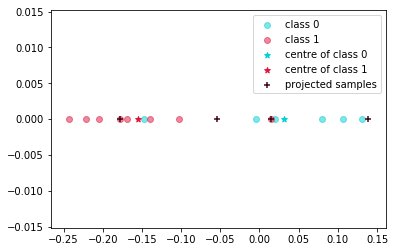

In [4]:
LDA_watermelon = LDA(dataset)
LDA_watermelon.training()
print('Accuracy on validation set:',"%.2f%%"  %(LDA_watermelon.validation()*100))
LDA_watermelon.visualization()